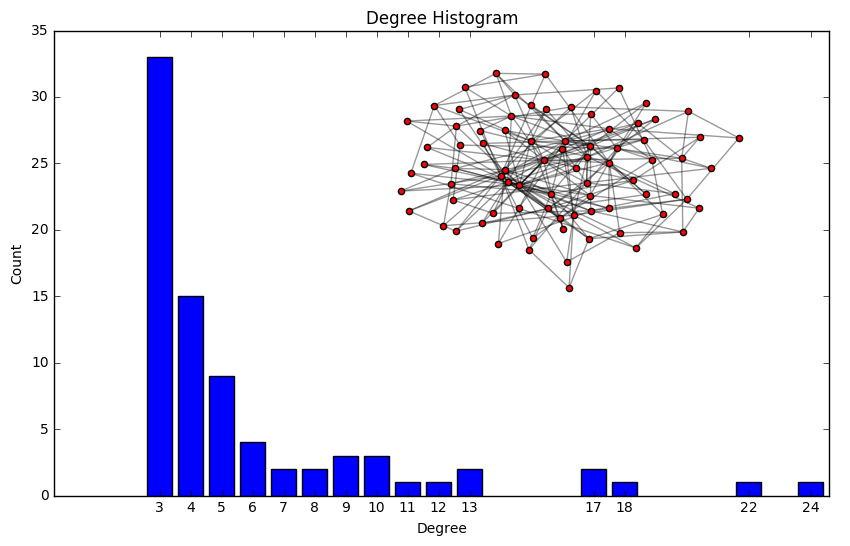

In [7]:
import networkx as nx
import random
import pylab as plt
import numpy as np
from IPython import display
import time
import collections

size = 80 # Graph size
m = 3 # Connectedness

p = 0.5 # Proportion of infected at the beginning
nu = 0.3 # Chance of getting infected
delta = 0.5 # Chance of recovering

def initialize_graph(N,m,p):
    graph = nx.barabasi_albert_graph(N,m)
    for i in range(N): # Initialize the state attribute for every node as susceptible
        graph.node[i]['state'] = 0
    for j in range(int(N*p)): # Infects the given initial proportion
        k = random.randint(0,N-1)
        graph.node[k]['state'] = 1
    return graph

def plotting(graph,pos,title): # Simple plotting algorithm that first makes the colormapping and draws its graph  
    colormap = []
    for i in range(len(graph.node)):
        if graph.node[i]['state'] == 0:
            colormap.append('blue')
        elif graph.node[i]['state'] == 1:
            colormap.append('red')
        elif graph.node[i]['state'] == 2:
            colormap.append('yellow')
        else:
            print("Not known state")
    plt.figure(figsize=(10,6))
    plt.title(title)
    return nx.draw(graph,pos,node_color=colormap,alpha=0.8)

# Initialize a graph, fix its position and copy it for the two types of simulations
graph = initialize_graph(size,m,p)
pos = nx.fruchterman_reingold_layout(graph)# Fixing the layout of the graph
#pos = nx.spring_layout(graph)
G_SIS = graph.copy()
G_SIR = graph.copy()

#Plotting the degree distribution
degree_sequence=sorted([graph.degree()[n] for n in graph.degree().keys()], reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
degreeCount=collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(10,6))
plt.bar(deg, cnt, width=0.80, color='b')
#plt.plot(range(m,max(deg)+1),[i**(-3) for i in range(m,max(deg)+1)], ls='--')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d+0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc=sorted(nx.connected_component_subgraphs(graph), key = len, reverse=True)[0]
plt.axis('off')
nx.draw_networkx_nodes(graph, pos, node_size=20)
nx.draw_networkx_edges(graph, pos, alpha=0.4)

plt.show()

In [2]:
### SIS simulation on a scale-free network ###

def SIS_step(graph): # Alters the graph by one time step
    prop = 0
    G_original = graph.copy()
    G_changed = G_original.copy()
    N = len(G_original.node)
    for i in range(N):
        # Finds out if the given node has infected neighbor(s) or not
        neighbors = G_original.neighbors(i)
        possibly_infected = False
        for j in neighbors:
            if G_original.node[j]['state'] != 0:
                possibly_infected = True
        # If the node is healty and it has an infected neighbor it gets maybe infected else if it is infected it maybe recovers
        if G_original.node[i]['state'] == 0 and possibly_infected:
            if np.random.uniform() <= nu:
                G_changed.node[i]['state'] = 1
                prop += 1
        elif G_original.node[i]['state'] == 1:
            if np.random.uniform() <= delta:
                G_changed.node[i]['state'] = 0
            else:
                prop += 1
        G_original = G_changed.copy()
    prop = prop/N
    return G_original, prop

def SIS_simulation(G,pos,steps,plot = True):
    proportions = [p]
    if plot:
        plotting(G,pos,"Network's state in time step {}".format(0))
        plt.show()
        time.sleep(0.4)
    for i in range(steps):
        G, prop = SIS_step(G)
        if plot:
            display.clear_output(wait=True)
            plotting(G,pos,"Network's state in time step {}".format(i+1))
            plt.show()
            time.sleep(0.4)
        proportions.append(prop)
    return proportions

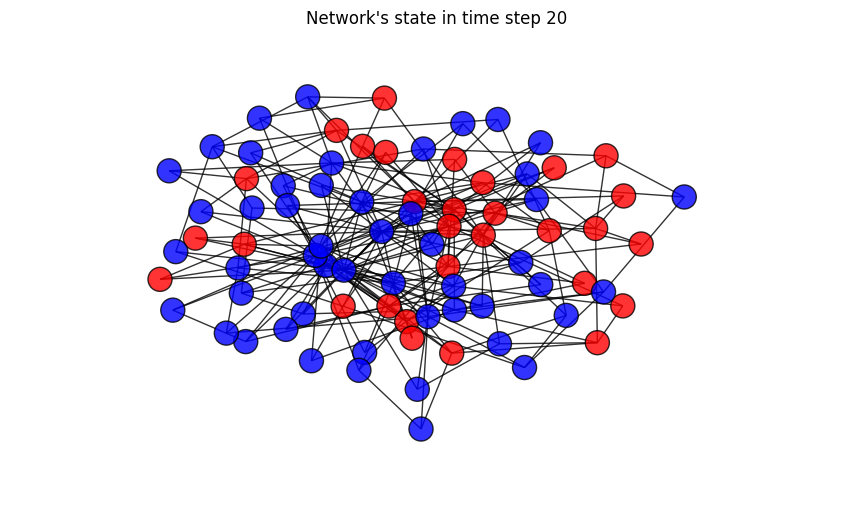

In [8]:
proportions_1 = SIS_simulation(G_SIS,pos,20)

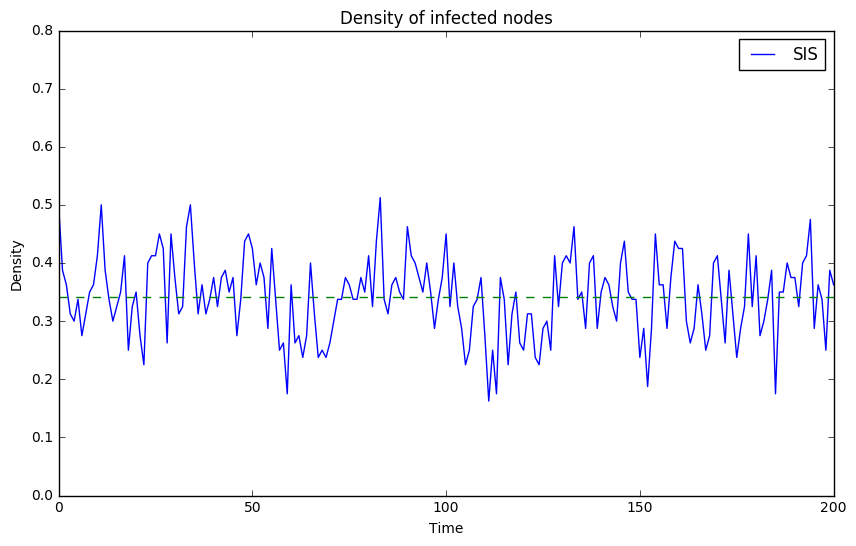

In [4]:
G_SIS = graph.copy()
proportions_1 = SIS_simulation(G_SIS,pos,200,plot=False)
plt.figure(figsize=(10,6))
plt.ylim([0,0.8])
plt.plot(proportions_1)
plt.plot([np.mean(proportions_1) for i in range(201)],ls='--')
plt.title("Density of infected nodes")
plt.legend(['SIS'], loc='upper right')
plt.ylabel("Density")
plt.xlabel("Time")
plt.show()

In [12]:
### SIR simulation on a scale-free network ###

def SIR_step(graph): # Alters the graph by one time step
    prop = 0
    G_original = graph.copy()
    G_changed = graph.copy()
    N = len(G_original.node)
    for i in range(N): # Iterates over the range of the number of nodes in the original graph
        # Finds out if the given node has infected neighbor(s) or not
        neighbors = G_original.neighbors(i)
        possibly_infected = False
        for j in neighbors:
            if G_original.node[j]['state'] == 1:
                possibly_infected = True
        # If the node is healty and it has an infected neighbor it gets maybe infected
        # If it is infected it maybe recovers
        # If it is recovered then it just skips that node
        if G_original.node[i]['state'] == 2:
            continue
        elif G_original.node[i]['state'] == 0 and possibly_infected:
            if np.random.uniform() <= nu:
                G_changed.node[i]['state'] = 1
                prop += 1
        elif G_original.node[i]['state'] == 1:
            if np.random.uniform() <= delta:
                G_changed.node[i]['state'] = 2
            else:
                prop += 1
        G_original = G_changed.copy()
    prop = prop/N
    return G_original, prop

def SIR_simulation(G,pos,plot=True):
    proportions = [p]
    if plot:
        plotting(G,pos,"Network's state in time step {}".format(0))
        plt.show()
        time.sleep(0.4)
    i = 0
    while proportions[-1] > 0: 
        G, prop = SIR_step(G)
        if plot:
            display.clear_output(wait=True)
            plotting(G,pos,"Network's state in time step {}".format(i+1))
            plt.show()
            time.sleep(0.4)
        proportions.append(prop)
        i += 1
    return proportions

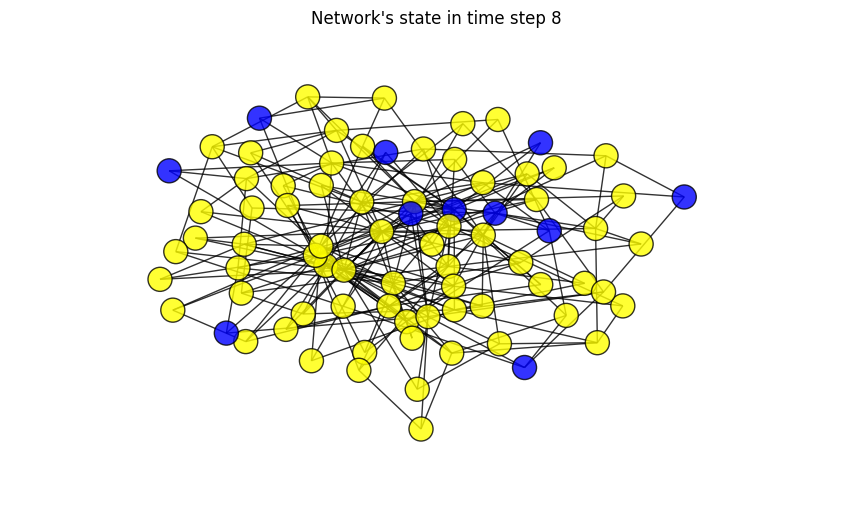

In [13]:
proportions_2 = SIR_simulation(G_SIR,pos)